# Save global SAH drag coefficient, M2, match the tides_01 grid, mask the shallow seas (< 1000 m)

In [1]:
%matplotlib inline

import numpy as np
import xesmf as xe
import xarray as xr
import netCDF4 as nc
import cmocean as cm
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.ticker
import matplotlib.colors as colors
from dask.distributed import Client
from matplotlib.colors import LogNorm
from scipy.interpolate import griddata
from gsw import f, Nsquared, p_from_z, z_from_p

import warnings
warnings.filterwarnings('ignore')

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43419,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 125.19 GiB
Comm: tcp://127.0.0.1:43543,Total threads: 4
Dashboard: /proxy/43789/status,Memory: 17.88 GiB
Nanny: tcp://127.0.0.1:44391,


In [3]:
nx, ny = 360, 270
# nx, ny = 1200, 900
yh = np.full((ny),np.nan)
xh = np.full((nx),np.nan)
lat = np.full((ny,nx),np.nan)
lon = np.full((ny,nx),np.nan)
depth_z = np.full((ny,nx),np.nan)

sigma_xx  = np.full((ny,nx),np.nan)
sigma_yy  = np.full((ny,nx),np.nan)
sigma_xy  = np.full((ny,nx),np.nan)
sigma_mag = np.full((ny,nx),np.nan)

## Loop through tiles and re-construct drag coefficient arrays

In [4]:
for i in range(900):
    if i % 100 == 0:
        print(i)
    # 1-deg
    filename = '/g/data/nm03/lxy581/global_drag_coeff/sigma_SAH_M2_1deg_2d_%03d.nc' % (i+1)
    # 1/3-deg
    # filename = '/g/data/nm03/lxy581/global_drag_coeff/sigma_SAH_M2_033deg_2d_%03d.nc' % (i+1)

    itile = xr.open_dataset(filename)

    # infer the lon & lat from itile
    ilon = i//30+1
    ilat = i+1 - (ilon-1)*30
    # print(ilon,ilat)
    # print(np.nanmin(np.array(itile.xh)))

    xh[(ilon-1)*12:ilon*12] = itile.xh
    yh[(ilat-1)*9:ilat*9] = itile.yh
    lon[(ilat-1)*9:ilat*9,(ilon-1)*12:ilon*12] = itile.lon 
    lat[(ilat-1)*9:ilat*9,(ilon-1)*12:ilon*12] = itile.lat
    sigma_xx[(ilat-1)*9:ilat*9,(ilon-1)*12:ilon*12] = itile.sigma_xx
    sigma_yy[(ilat-1)*9:ilat*9,(ilon-1)*12:ilon*12] = itile.sigma_yy
    sigma_xy[(ilat-1)*9:ilat*9,(ilon-1)*12:ilon*12] = itile.sigma_xy

sigma_mag = np.sqrt(sigma_xx**2+sigma_yy**2)

0
100
200
300
400
500
600
700
800


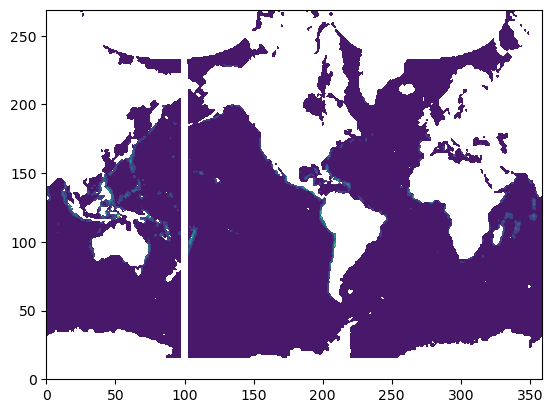

In [5]:
plt.contourf(sigma_xx)

## Ocean depth

In [6]:
# topog = xr.open_dataset('/g/data/nm03/lxy581/synbath/SYNBATH.nc')

# def get_depth(lon,lat):
#     return topog.z.interp(lat=lat,lon=lon).values

In [7]:
# for j in range(ny):
#     if j % 90 == 0:
#         print(j)
#     for i in range(nx):
#         # print('lon = ', lon[j,i])
#         # print('lat = ', lat[j,i])
#         depth_z[j,i] = get_depth(lon[j,i],lat[j,i])
#         # print('depth = ', depth_z[j,i])

In [8]:
depth_data = xr.open_dataset('/g/data/nm03/lxy581/global_drag_coeff/depth_SAH_M2_01_1deg_2d_global.nc')
depth_z = np.array(depth_data.depth_z)

In [9]:
depth_z[depth_z>0]=np.nan
depth_xr = xr.DataArray(depth_z, 
                        coords={'lat': (('yh','xh'), lat), 
                                'lon': (('yh','xh'), lon),}, 
                        dims=["yh", "xh"])

In [10]:
np.nanmean(depth_z)

-3211.5358350614288

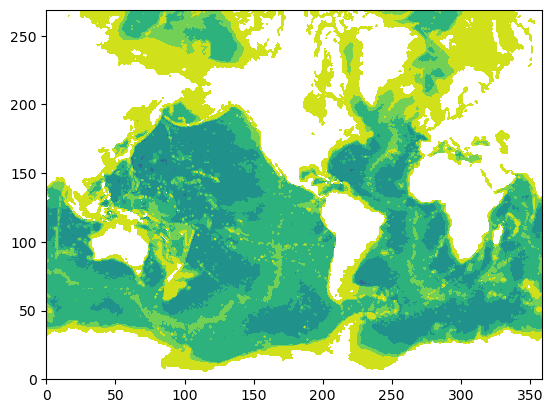

In [11]:
plt.contourf(depth_z)

In [12]:
# depth_data = xr.Dataset(data_vars={"depth_z": (["yh","xh"], depth_z),
#                                   },
#                         coords={'lat': (('yh','xh'), lat), 
#                                 'lon': (('yh','xh'), lon),}
#                         )
# depth_data.to_netcdf('/g/data/nm03/lxy581/global_drag_coeff/depth_SAH_M2_01_1deg_2d_global.nc')

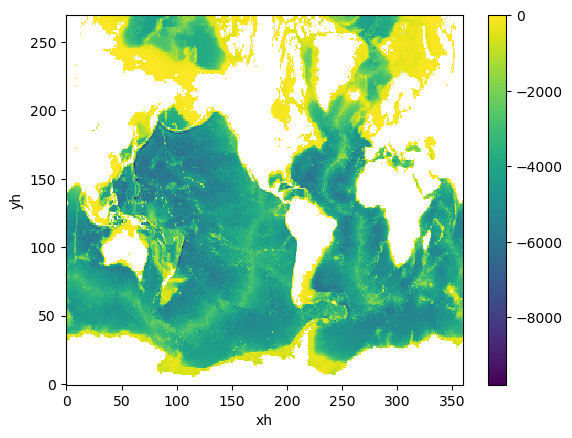

In [13]:
depth_xr.plot()

In [14]:
sigma_xx_xr  = xr.DataArray(sigma_xx, 
                            coords={'lat': (('yh','xh'), lat), 
                                    'lon': (('yh','xh'), lon),}, 
                            dims=["yh", "xh"])
sigma_yy_xr  = xr.DataArray(sigma_yy, 
                            coords={'lat': (('yh','xh'), lat), 
                                    'lon': (('yh','xh'), lon),}, 
                            dims=["yh", "xh"])
sigma_xy_xr  = xr.DataArray(sigma_xy, 
                            coords={'lat': (('yh','xh'), lat), 
                                    'lon': (('yh','xh'), lon),}, 
                            dims=["yh", "xh"])
sigma_mag_xr = xr.DataArray(sigma_mag, 
                            coords={'lat': (('yh','xh'), lat), 
                                    'lon': (('yh','xh'), lon),}, 
                            dims=["yh", "xh"])

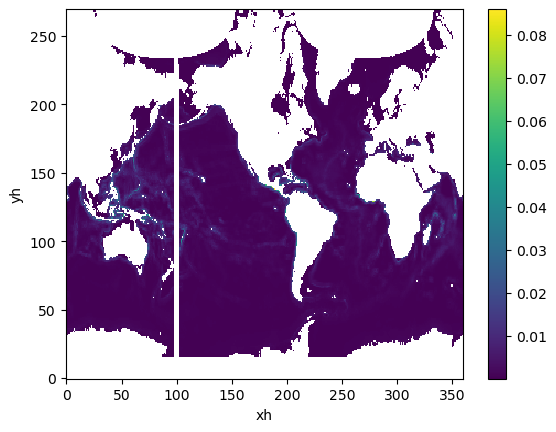

In [25]:
sigma_mag_xr.plot()

## Interpolate to remove the missing band near 180°

In [16]:
mask_array = ~np.isnan(np.array(sigma_xx_xr))
ds = xr.Dataset(data_vars={
                'sigma_xx_xr': (('yh','xh'), np.array(sigma_xx_xr)),
                'sigma_yy_xr': (('yh','xh'), np.array(sigma_yy_xr)),
                'sigma_xy_xr': (('yh','xh'), np.array(sigma_xy_xr)),
                'sigma_mag_xr': (('yh','xh'), np.array(sigma_mag_xr)),
                'mask': (('yh','xh'), mask_array)
                }, 
                coords={'lon': (('yh','xh'), np.array(sigma_xx_xr.lon)),
                        'lat': (('yh','xh'), np.array(sigma_xx_xr.lat))})
ds_out = xr.Dataset({"lat": (('yh','xh'), lat),
                     "lon": (('yh','xh'), lon),
                     "mask": (('yh','xh'), ~np.isnan(depth_z))})
regridder = xe.Regridder(ds, ds_out, "bilinear", extrap_method="inverse_dist")
ds_out = regridder(ds)

[gadi-cpu-bdw-0285.gadi.nci.org.au:839567] shmem: mmap: an error occurred while determining whether or not /jobfs/126758118.gadi-pbs/ompi.gadi-cpu-bdw-0285.10115/jf.0/756023296/shared_mem_cuda_pool.gadi-cpu-bdw-0285 could be created.
[gadi-cpu-bdw-0285.gadi.nci.org.au:839567] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 


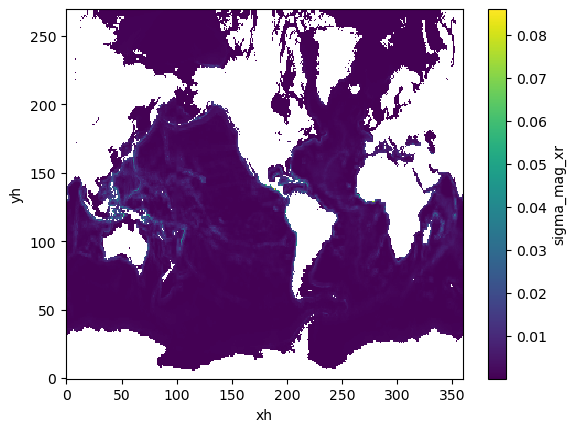

In [26]:
ds_out.sigma_mag_xr.plot()

## Interpolate to 1/10° grid

In [17]:
fgrid = '/g/data/nm03/lxy581/archive/tides_01_global_cdrag_const/output000/ocean_static.nc' 
hgrid = xr.open_dataset(fgrid)
mom_xh = np.array(hgrid.xh)
mom_yh = np.array(hgrid.yh)
mom_xq = np.array(hgrid.xq)
mom_yq = np.array(hgrid.yq)
deptho = np.array(hgrid.deptho)
mom_nyh, mom_nxh = mom_yh.size, mom_xh.size
mom_nyq, mom_nxq = mom_yq.size, mom_xq.size

In [18]:
geolon = np.array(hgrid['geolon'])
geolat = np.array(hgrid['geolat'])
geolon_u = np.array(hgrid['geolon_u'])
geolat_u = np.array(hgrid['geolat_u'])
geolon_v = np.array(hgrid['geolon_v'])
geolat_v = np.array(hgrid['geolat_v'])

In [19]:
ds_low = xr.Dataset(data_vars={'sigma_mag_01': (('yh','xh'), np.array(ds_out['sigma_mag_xr'])),
                               'sigma_xx_01': (('yh','xh'), np.array(ds_out['sigma_xx_xr'])),
                               'sigma_yy_01': (('yh','xh'), np.array(ds_out['sigma_yy_xr'])),
                               'sigma_xy_01': (('yh','xh'), np.array(ds_out['sigma_xy_xr'])),
                               'mask': (('yh','xh'), ~np.isnan(depth_z))
                               }, 
                    coords={'lon': (('yh','xh'), np.array(sigma_xx_xr.lon)),
                            'lat': (('yh','xh'), np.array(sigma_xx_xr.lat))})
ds_high_h = xr.Dataset(data_vars={"lat": (["ny"], mom_yh),
                                  "lon": (["nx"], mom_xh),
                                 },
                       coords={"ny":np.arange(mom_nyh), "nx":np.arange(mom_nxh)})
ds_high_u = xr.Dataset(data_vars={"lat": (["ny"], mom_yh),
                                  "lon": (["nx"], mom_xq),
                                 },
                       coords={"ny":np.arange(mom_nyh), "nx":np.arange(mom_nxq)})
ds_high_v = xr.Dataset(data_vars={"lat": (["ny"], mom_yq),
                                  "lon": (["nx"], mom_xh),
                                 },
                       coords={"ny":np.arange(mom_nyq), "nx":np.arange(mom_nxh)})
regridder2_h = xe.Regridder(ds_low, ds_high_h, "bilinear", extrap_method="inverse_dist")
regridder2_u = xe.Regridder(ds_low, ds_high_u, "bilinear", extrap_method="inverse_dist")
regridder2_v = xe.Regridder(ds_low, ds_high_v, "bilinear", extrap_method="inverse_dist")
ds_high_h = regridder2_h(ds_low)
ds_high_u = regridder2_u(ds_low)
ds_high_v = regridder2_v(ds_low)

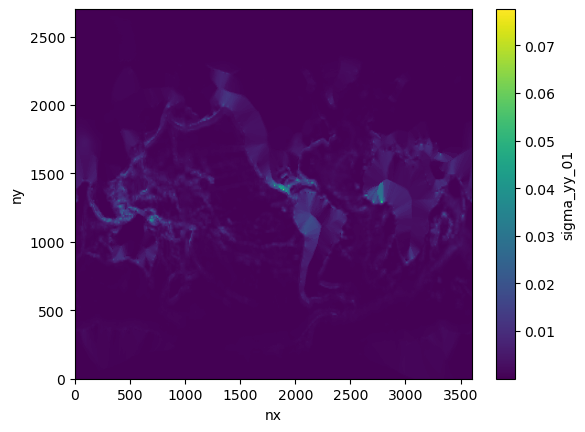

In [29]:
ds_high_v['sigma_yy_01'].plot()

In [34]:
ds_low_dep = xr.Dataset(data_vars={
                                   'depth_01': (('yh','xh'), depth_z),
                                   }, 
                        coords={"lat": (('yh','xh'), lat),
                                "lon": (('yh','xh'), lon)})
ds_high_dep_h = xr.Dataset(data_vars={"lat": (["ny"], mom_yh),
                                      "lon": (["nx"], mom_xh),
                                     },
                           coords={"ny":np.arange(mom_nyh), "nx":np.arange(mom_nxh)})
ds_high_dep_u = xr.Dataset(data_vars={"lat": (["ny"], mom_yh),
                                      "lon": (["nx"], mom_xq),
                                     },
                           coords={"ny":np.arange(mom_nyh), "nx":np.arange(mom_nxq)})
ds_high_dep_v = xr.Dataset(data_vars={"lat": (["ny"], mom_yq),
                                      "lon": (["nx"], mom_xh),
                                     },
                           coords={"ny":np.arange(mom_nyq), "nx":np.arange(mom_nxh)})
regridder3_h = xe.Regridder(ds_low_dep, ds_high_dep_h, "bilinear", extrap_method="inverse_dist")
regridder3_u = xe.Regridder(ds_low_dep, ds_high_dep_u, "bilinear", extrap_method="inverse_dist")
regridder3_v = xe.Regridder(ds_low_dep, ds_high_dep_v, "bilinear", extrap_method="inverse_dist")

ds_high_dep_h = regridder3_h(ds_low_dep)
ds_high_dep_u = regridder3_u(ds_low_dep)
ds_high_dep_v = regridder3_v(ds_low_dep)

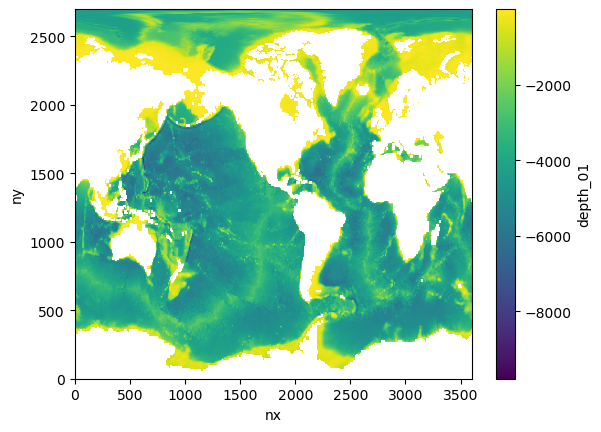

In [35]:
ds_high_dep_h['depth_01'].plot()

### Critical latitude for M2

In [21]:
omega = 2 * np.pi / (12.42*3600)
f_loc = f(74.48) 
print(omega)
print(f_loc)

0.0001405257046694307
0.00014052446836156188


### Save JSL drag coefficient to file

In [36]:
dep_global_h = np.array(ds_high_dep_h['depth_01'])
dep_global_u = np.array(ds_high_dep_u['depth_01'])
dep_global_v = np.array(ds_high_dep_v['depth_01'])

def make_nan_poleward_critical_lat(var,dep_var,mom_lat,mom_lon):
    var_global = np.zeros(np.array(var).shape)
    var_global = np.array(var)
    var_global[np.isnan(dep_var)==1]=0.0
    var_global[mom_lat>74.48]=0.0
    var_global[mom_lat<-74.48]=0.0
    return var_global

fac_dep = xr.where(ds_high_dep_h["depth_01"] < -1000, 1, 0)
fac_dep_v = xr.where(ds_high_dep_v["depth_01"] < -1000, 1, 0) 
fac_dep_u = xr.where(ds_high_dep_u["depth_01"] < -1000, 1, 0)

SAH_xx_global  = make_nan_poleward_critical_lat(ds_high_u['sigma_xx_01'],dep_global_u,mom_yh,mom_xq) * np.array(fac_dep_u) 
SAH_yy_global  = make_nan_poleward_critical_lat(ds_high_v['sigma_yy_01'],dep_global_v,mom_yq,mom_xh) * np.array(fac_dep_v)
SAH_xy_global  = make_nan_poleward_critical_lat(ds_high_h['sigma_xy_01'],dep_global_h,mom_yh,mom_xh) * np.array(fac_dep)
SAH_mag_global = make_nan_poleward_critical_lat(ds_high_h['sigma_mag_01'],dep_global_h,mom_yh,mom_xh) * np.array(fac_dep)

SAH_data = xr.Dataset(data_vars={"sigma_mag": (["nyh","nxh"], SAH_mag_global),
                                 "sigma_xx": (["nyh","nxq"], SAH_xx_global),
                                 "sigma_yy": (["nyq","nxh"], SAH_yy_global),
                                 "sigma_xy": (["nyh","nxh"], SAH_xy_global),
                                 "geolon": (["nyh","nxh"], geolon),
                                 "geolat": (["nyh","nxh"], geolat),
                                 "geolon_u": (["nyh","nxq"], geolon_u),
                                 "geolat_u": (["nyh","nxq"], geolat_u),
                                 "geolon_v": (["nyq","nxh"], geolon_v),
                                 "geolat_v": (["nyq","nxh"], geolat_v),
                                },
                      coords={"yh": (["nyh"], np.array(hgrid.yh)),
                            "yq": (["nyq"], np.array(hgrid.yq)),
                            "xq": (["nxq"], np.array(hgrid.xq)),
                            "xh": (["nxh"], np.array(hgrid.xh))},
                      attrs={'long_name': 'SAH drag coefficient (M2)', 'units': 'm second-1'})

SAH_data.to_netcdf('/g/data/nm03/lxy581/global_drag_coeff/sigma_SAH_M2_01_1deg_2d_global.nc')

## Plot drag coefficient

See **plot_drag_coeff_global_SAH_M2_01deg.ipynb**